<a href="https://colab.research.google.com/github/avx03/Final-Big-Data/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2ff5c59bd435a2cf6035b777d8875b065fc7ad136b0ccd40cc7e0badf7031d23
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


1. Initiate Spark environment¶


In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

In [ ]:
spark_session = SparkSession.builder.master("local[2]").appName("HousingRegression").getOrCreate()


In [ ]:
spark_context = spark_session.sparkContext


In [ ]:
spark_sql_context = SQLContext(spark_context)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


2. Loading data & EDA¶


In [ ]:
TRAIN_INPUT = 'train.csv'
TEST_INPUT = 'test.csv'

First, let's us pandas to handle the missing data and do some visualizations.

In [ ]:
pd_train = pd.read_csv(TRAIN_INPUT)
pd_test = pd.read_csv(TEST_INPUT)
na_cols = pd_train.columns[pd_train.isna().any()].tolist()

QQ-plot



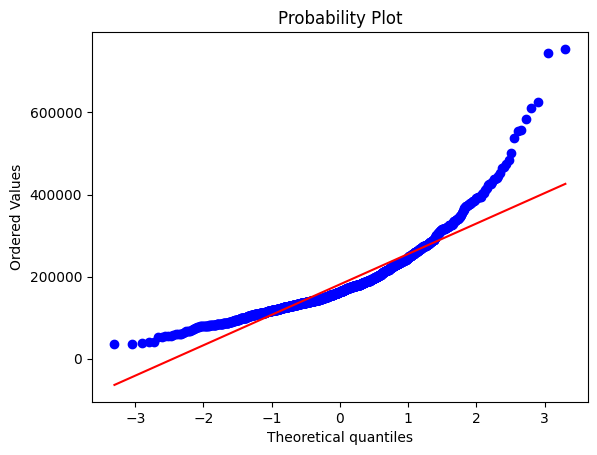

In [ ]:
# Let's Explore how SalePrice is distributed against normal theoretical quantiles
fig = plt.figure()
ax = fig.add_subplot()
res = stats.probplot(pd_train['SalePrice'], plot=plt)

Dist plot (normal vs factual distribution of SalePrice)



<ipython-input-12-c84ecbd7a0ee>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd_train['SalePrice'] , fit=norm);


Text(0.5, 1.0, 'SalePrice distribution')

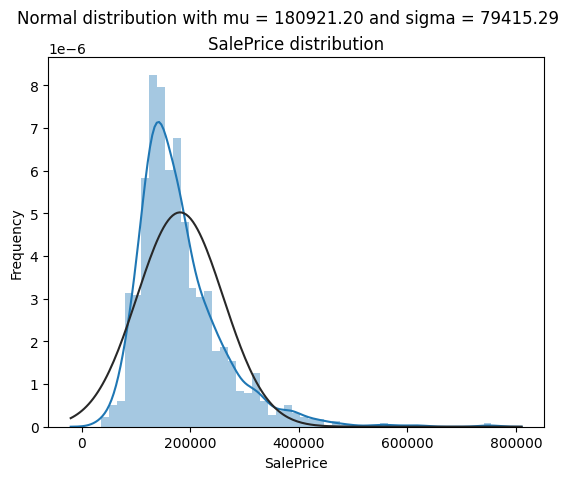

In [ ]:
sns.distplot(pd_train['SalePrice'] , fit=norm);

# parameters
(mu, sigma) = norm.fit(pd_train['SalePrice'])

plt.suptitle('Normal distribution with mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#ax = plt.axes()

Now let's build a correlation matrix



In [ ]:
corr = pd_train.corr()


ValueError: could not convert string to float: 'RL'

In [ ]:
corr[['SalePrice']].sort_values(by='SalePrice',ascending=False).style.background_gradient(cmap='viridis', axis=None)

We can see that the top-10 features have a high correlation level with the target variable.



A good idea would be to create a new feature with 3-4 of top-features combined, which we will try later. [see "New" Feature]



Now let's explore the dataset for outliers.



In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0,10)

sns.scatterplot(data=pd_train, ax=axes[0], x='OverallQual', y='SalePrice')
axes[0].set_title('OverallQual vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='GarageCars', y='SalePrice')
axes[1].set_title('GarageCars vs SalePrice')

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='GrLivArea', y='SalePrice')
axes[0].set_title('GrLivArea vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='GarageArea', y='SalePrice')
axes[1].set_title('GarageArea vs SalePrice')

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='TotalBsmtSF', y='SalePrice')
axes[0].set_title('TotalBsmtSF vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='1stFlrSF', y='SalePrice')
axes[1].set_title('1stFlrSF vs SalePrice')

Handling missing data:¶


determining the proportion of missing data from overall dataset.



In [ ]:
total = pd_train.isnull().sum().sort_values(ascending=False)
percent = (pd_train.isnull().sum()/pd_train.shape[0]).sort_values(ascending=False)

missing = pd.concat([total, percent], axis=1, keys=['Total', 'Perc_missing'])
missing.head(15)

In [ ]:
# We will remove features with missing proportion of more than 15% (thumb rule)

pd_train = pd_train.drop((missing[missing['Perc_missing'] >= 0.15]).index,1)
pd_train.head()

In [ ]:
pd_train['New'] = pd_train['OverallQual'] * pd_train['GarageArea'] * pd_train['GrLivArea']
pd_test['New'] = pd_test['OverallQual'] * pd_test['GarageArea'] * pd_test['GrLivArea']

# As some of the contestants have noticed, this results in a spike in model performance later

In [ ]:
train_cols = list(pd_train.columns)
train_cols.remove('SalePrice')

In [ ]:
#Make test ds feature set same as in train ds
pd_test = pd_test[train_cols]

In [ ]:
pd_test.columns[pd_test.isna().any()].tolist()


In [ ]:
# Althoug this is not the best solution to fill the NA-values with "None"/0, for most of the features
# in the particular datas, it literally means "None"/0 (e.g. Garage Area, Garage Type, Condition) as the house
# probably doesn't have the garage.

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    pd_train[col] = pd_train[col].fillna(0)
    pd_test[col] = pd_test[col].fillna(0)

pd_train['MasVnrType'] = pd_train['MasVnrType'].fillna("None")
pd_test['MasVnrType'] = pd_test['MasVnrType'].fillna("None")

pd_train['MasVnrArea'] = pd_train['MasVnrArea'].fillna(0)
pd_test['MasVnrArea'] = pd_test['MasVnrArea'].fillna(0)

pd_train['Electrical'] = pd_train['Electrical'].fillna(pd_train['Electrical'].mode()[0])
pd_test['Electrical'] = pd_test['Electrical'].fillna(pd_test['Electrical'].mode()[0])

print(pd_train.isnull().sum().max()) # check if any missing values are left
print(pd_test.isnull().sum().max())

In [ ]:
pd_test['BsmtFinSF1'] = pd_test['BsmtFinSF1'].fillna(pd_test['BsmtFinSF1'].mean())
pd_test['BsmtFinSF2'] = pd_test['BsmtFinSF2'].fillna(pd_test['BsmtFinSF2'].mean())
pd_test['BsmtUnfSF'] = pd_test['BsmtUnfSF'].fillna(pd_test['BsmtUnfSF'].mean())
pd_test['TotalBsmtSF'] = pd_test['TotalBsmtSF'].fillna(pd_test['TotalBsmtSF'].mean())
pd_test['BsmtFullBath'] = pd_test['BsmtFullBath'].fillna(pd_test['BsmtFullBath'].mean())
pd_test['BsmtHalfBath'] = pd_test['BsmtHalfBath'].fillna(pd_test['BsmtHalfBath'].mean())

In [ ]:
# This is how fillna is done in PySpark

# train_df = train_df.na.fill('NoData', subset=['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1',
#       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
#       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea','SaleType'])
# test_df = test_df.na.fill('NoData', subset=['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1',
#       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
#       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea','SaleType'])

In [ ]:
cat_columns = pd_train.select_dtypes(include=['object']).columns
pd_train[cat_columns] = pd_train[cat_columns].fillna('NoData')
pd_test[cat_columns] = pd_test[cat_columns].fillna('NoData')

**Handling outliers:**


the values are based on the scatterplots above.



In [ ]:
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>4500)
                                & (pd_train['SalePrice']<300000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>5500)
                                | (pd_train['SalePrice']>500000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[pd_train['GarageArea']>1100].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))

Creating Spark DataFrames


In [ ]:
train_df = spark_session.createDataFrame(pd_train)
test_df = spark_session.createDataFrame(pd_test)

In [ ]:
train_df = train_df.select([c for c in train_df.columns if c not in na_cols])
train_cols = train_df.columns
train_cols.remove('SalePrice')
test_df = test_df.select(train_cols)

In [ ]:
from pyspark.sql.types import IntegerType

# As PySpark DFs can be finicky, sometimes your have to explicitly cast certain data types to columns

test_df = test_df.withColumn("BsmtFinSF1", test_df["BsmtFinSF1"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFinSF2", test_df["BsmtFinSF2"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtUnfSF", test_df["BsmtUnfSF"].cast(IntegerType()))
test_df = test_df.withColumn("TotalBsmtSF", test_df["TotalBsmtSF"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFullBath", test_df["BsmtFullBath"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtHalfBath", test_df["BsmtHalfBath"].cast(IntegerType()))
test_df = test_df.withColumn("GarageCars", test_df["GarageCars"].cast(IntegerType()))
test_df = test_df.withColumn("GarageArea", test_df["GarageArea"].cast(IntegerType()))

# train_df.printSchema()

In [ ]:
# Defining string columns to pass on to the String Indexer (= categorical feature encoding)

train_string_columns = []

for col, dtype in train_df.dtypes:
    if dtype == 'string':
        train_string_columns.append(col)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(train_df) for column in train_string_columns]


pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train_df).transform(train_df)

In [ ]:
print(len(train_indexed.columns))


In [ ]:
test_string_columns = []

for col, dtype in test_df.dtypes:
    if dtype == 'string':
        test_string_columns.append(col)

In [ ]:
indexers2 = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(test_df) for column in test_string_columns]

pipeline2 = Pipeline(stages=indexers2)
test_indexed = pipeline2.fit(test_df).transform(test_df)

In [ ]:
print(len(test_indexed.columns))

In [ ]:
def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

num_cols_train = []
for col in train_indexed.columns:
    if get_dtype(train_indexed,col) != 'string':
        num_cols_train.append(str(col))

num_cols_test = []
for col in test_indexed.columns:
    if get_dtype(test_indexed,col) != 'string':
        num_cols_test.append(str(col))

train_indexed = train_indexed.select(num_cols_train)
test_indexed = test_indexed.select(num_cols_test)

In [ ]:
print(len(train_indexed.columns))
print(len(test_indexed.columns))

**3. Model building (MLlib)**



Before passing the data on to the PySpark model, we need to vectorize the data.



In [ ]:
from pyspark.ml.feature import VectorAssembler
#Combine columns of a DataFrame 'train_indexed' excluding the "SalePrice" column into a new column containing vectors "features".
#If there are any invalid values in any column, they will be preserved and treated as 0 in the resulting vector.
vectorAssembler = VectorAssembler(inputCols = train_indexed.drop("SalePrice").columns, outputCol = 'features').setHandleInvalid("keep")

#Create a new DataFrame (train_vector) by adding a column 'features' to train_indexed.
train_vector = vectorAssembler.transform(train_indexed)

In [ ]:
# Combine all the columns of the DataFrame 'test_indexed'
vectorAssembler2 = VectorAssembler(inputCols = test_indexed.columns, outputCol = 'features').setHandleInvalid("keep")

test_vector = vectorAssembler2.transform(test_indexed)

In [ ]:
from pyspark.sql.functions import lit

test_vector = test_vector.withColumn("SalePrice", lit(0))

In [ ]:
#You can use this to scale all instances, however, as I checked, this did not improve the performance

#from pyspark.ml.feature import StandardScaler
#scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
#scalerModel = scaler.fit(train_vector)
#scaled_train = scalerModel.transform(train_vector)

#scalerModel2 = scaler.fit(test_vector)
#scaled_test = scalerModel2.transform(test_vector)

In [ ]:
# Train-test split

splits = train_vector.randomSplit([0.7, 0.3])
train = splits[0]
val = splits[1]

In [ ]:
# Simple baseline (linreg)

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='SalePrice', maxIter=10,
                      regParam=0.8, elasticNetParam=0.1) # It is always a good idea to play with hyperparameters.
lr_model = lr.fit(train)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

lr_predictions = lr_model.transform(val)
lr_predictions.select("prediction","SalePrice","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % lr_evaluator.evaluate(lr_predictions))

In [ ]:
# A more complex model with RF

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'features', labelCol='SalePrice',
                           maxDepth=20,
                           minInstancesPerNode=2,
                           bootstrap=True
                          )
rf_model = rf.fit(train)

rf_predictions = rf_model.transform(val)
rf_predictions.select("prediction","SalePrice","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))

**4. Making predictions & submission**


Let's convert the predictions in the .csv file for submission



In [ ]:
rf_predictions2 = rf_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = rf_predictions2.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

from pyspark.sql.types import FloatType, IntegerType

#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))


In [ ]:
pred_pd = pred.toPandas()
save = pred_pd.to_csv("sample_submission.csv", index=False)
save

In [ ]:
pred_pd

5. Conclusion


PySpark offers way less flexibility in working with data & models. This notebook represents just an exercise in using it. As for this particular dataset, you'd better use classical instruments.



However, we achieved quite good metrics of R^2~0.9 with Linear Regression and Random Forest Regression.



